# Modelling Corrosion

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy
import scipy

$$\require{mhchem}$$

### Going from reported corrosion rates to reaction rates

Corrosion rates are reported in thickness loss per time, for example an estimated atmospheric corrosion rate of atmospheric steel might be $20 \frac{\mu m}{year}$. With this, we can use the density of the material and the molar mass to convert thickness loss per time to moles of oxidized material per area per time. For example, using the values for carbon steel:

$$
20 \frac{\mu m}{yr} = 0.02 \frac{mm}{yr} = 0.002 \frac{cm}{yr} \\
\\
\rho = 7.84 \frac{g}{cm^{3}} \\
Molar\ mass = M = 57.0 \frac{g steel}{mol Fe} \\
\\
\frac{thickness\ loss}{time} * \frac{\rho}{M} = 0.002 \frac{cm}{yr} * \frac{7.84 \frac{g}{cm^{3}}}{57.0 \frac{g steel}{mol Fe}} = 2.75E-4 \frac{cm*g*mol\ Fe}{cm^{3}*g*yr} = 2.75E-4 \frac{mol\ Fe}{cm^{2}*yr}
$$


In [2]:
# Converting thickness loss to moles per year

thickness_loss = 0.002
density = 7.84
molar_mass = 57.0

ox_rate = thickness_loss * (density / molar_mass)
print(ox_rate)

0.0002750877192982456


This rate can be divided by the number of seconds in a year, 31,556,926, to convert to moles per second:

$$
2.75E-4 \frac{mol\ Fe}{yr} * \frac{1 yr}{31,556,926 sec} = 8.72E-12 \frac{mol\ Fe}{cm^{2}*sec}
$$

In [3]:
# Convert to moles per second

ox_rate_sec = ox_rate / 31556926
print(ox_rate_sec)

8.717189985432853e-12


This is certainly a huge oversimplification, as atmospheric corrosion tends to vary over time due to many factors such as humidity, precipitation, and air quality. Using this "average oxidation rate per second" will hopefully allow us to start with a crude, simple model which can be improved upon.

### Chemical reactions

Here we will also start very simply, with iron oxidation and oxygen reduction as the first reactions we will look at.

$$
\ce{Fe -> Fe^{2+} + 2e-}\\
\ce{O2 + 2H2O + 4e- -> 4OH-}
$$

Since 2 moles of electrons are produced for every mole of iron that is oxidized, and the reduction of 1 mole of oxygen requires 4 moles of electrons, 2 moles of iron oxidize for every mole of oxygen that is reduced. In the very simple case where these are the only two reactions occurring, this means that the reaction rate of oxygen reduction is half that of iron oxidation. 

$$
8.72E-12 \frac{mol\ \ce{Fe}}{cm^{2}*sec} * \frac{1 mol\ \ce{O2}}{2 mol\ \ce{Fe}} = 4.36E-12 \frac{mol\ \ce{O2}}{cm^{2}*sec}
$$

In [4]:
# Find oxygen reduction reaction (ORR) rate

orr_rate_sec = ox_rate_sec / 2
print(orr_rate_sec)

4.358594992716427e-12


Usually in corrosion systems the pH is of great interest, so we should also look at the hydroxide production rate. For each mole of oxygen that gets reduced, 4 moles of hydroxide are produced. 

$$
4.36E-12 \frac{mol\ \ce{O2}}{cm^{2}*sec} * \frac{4\ mol\ \ce{OH-}}{1\ mol\ \ce{O2}} = 1.74E-11 \frac{mol\ \ce{OH-}}{cm^{2}*sec}
$$

In [5]:
# Find hydroxide production rate

OH_prod_rate = orr_rate_sec * 4
print(OH_prod_rate)

1.7434379970865707e-11


### Starting a model

I want to start with a very basic model, and just look at the pH change over time with the hydroxide production rate I found above. I will start with a 1 cm x 1 cm steel surface, with 1 cm of water over it. The volume of the "water column" above the steel is then 1 cm^3 or 1 mL. 

This first model will be assumed to start at pH = 7, and will run for 10 seconds. In order to reduce the calculations at each step, the model will track the $\ce{OH-}$ concentration at each step, and convert those to pH values after all the steps are done.

$\ce{OH-}$ concentration in moles per liter ($[\ce{OH-}]$) calculation:

$$
[\ce{OH-}]_{new} = \frac{[\ce{OH-}]_{old} * volume + moles\ \ce{OH-}\ produced}{volume} = [\ce{OH-}]_{old} + \frac{moles\ \ce{OH-}\ produced}{volume}
$$


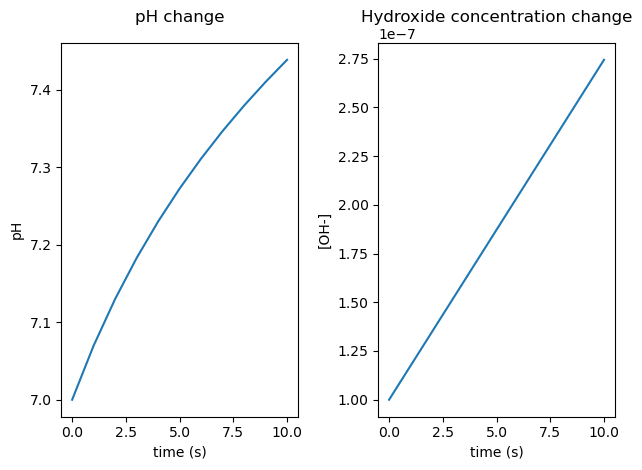

In [6]:
# Simple model run

number_of_seconds = 10
area = 1 # area of steel surface in cm^2
film_thickness = 1 # height of water over steel surface in cm
vol = area * film_thickness * 10**(-3) # find volume in cm^3, convert to liters (1000 cm^3 per liter)
initial_pH = 7



#set up array for tracking [OH-]

corrosion = np.zeros((2, number_of_seconds + 1)) # axis: 0-time, 1-[OH-]
corrosion[0] = np.array(range(number_of_seconds + 1))
corrosion[1, 0] = 10**(-(14-initial_pH)) # convert initial pH to [OH-]

for i in range(1, number_of_seconds + 1):
    moles_OH = OH_prod_rate * area
    corrosion[1, i] = corrosion[1, i-1] + (moles_OH / vol)

pH_values = 14 - (-np.log10(corrosion[1]))
# plot the results

fig, axs = plt.subplots(1, 2)

axs[0].plot(corrosion[0], pH_values)
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("pH")
axs[0].set_title("pH change", pad=15)

axs[1].plot(corrosion[0], corrosion[1])
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("[OH-]")
axs[1].set_title("Hydroxide concentration change", pad=15)

fig.tight_layout();



My next thought was to try and solve the water equilibrium expression at each time step. We know the autoionization reaction of water:

$$
\ce{2H2O <=> OH- + H3O+}
$$

and the corresponding equilibrium constant:

$$
K_w = [\ce{H3O+}][\ce{OH-}] = 10^{-14}
$$

Here water is ignored in the equilibrium constant expression because its activity is assumed to be 1, and hydroxide and hydronium activities are assumed to be equal to their concentrations. If we assume this reaction goes to equilibrium each second (yet another assumption), and we know that we have only added hydroxide, the equilibrium will be pushed toward the left side of the equation and the equilibrium constant calculation will have the form:

$$
10^{-14} = ([\ce{H3O+}] - x)([\ce{OH-}] - x)
$$

We know the starting concentrations of both $\ce{OH-}$ and $\ce{H3O+}$ because we specify the starting pH, so at each time step we can add the hydroxide amount and then solve for x, tracking both concentrations over time. In this case, I use the `fsolve()` function from the `scipy.optimize` library.

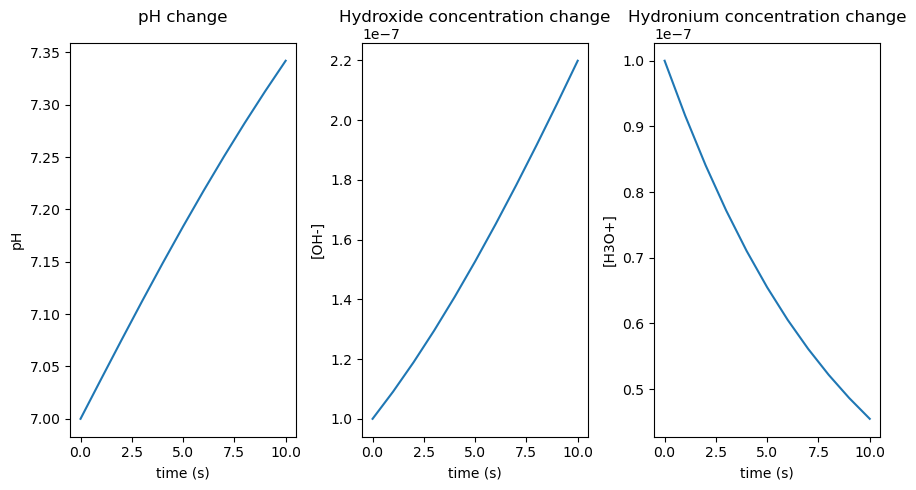

In [7]:
# Model run solving for water equilibrium at each step

number_of_seconds = 10
area = 1 # area of steel surface in cm^2
film_thickness = 1 # height of water over steel surface in cm
vol = area * film_thickness * 10**(-3) # find volume in cm^3, convert to liters (1000 cm^3 per liter)
initial_pH = 7



#set up array for tracking [OH-]

corrosion = np.zeros((3, number_of_seconds + 1)) # axis: 0-time, 1-[OH-], 2-[H3O+]
corrosion[0] = np.array(range(number_of_seconds + 1))
corrosion[1, 0] = 10**(-(14-initial_pH)) # convert initial pH to [OH-]
corrosion[2, 0] = 10**(-initial_pH) # convert initial pH to [H3O+]

#describe equilibrium equation with a function

def water_equilibrium(x, OH_conc, H3O_conc):
    return (OH_conc - x)*(H3O_conc - x) - 10**(-14)

#run model

for i in range(1, number_of_seconds + 1):
    moles_OH = OH_prod_rate * area
    new_conc_OH = corrosion[1, i-1] + (moles_OH / vol)
    change = scipy.optimize.fsolve(water_equilibrium, 0, args=(new_conc_OH, corrosion[2, i-1]))
    corrosion[1, i] = new_conc_OH - change
    corrosion[2, i] = corrosion[2, i-1] - change

pH_values = 14 - (-np.log10(corrosion[1]))
# plot the results

fig, axs = plt.subplots(1, 3, figsize=(9,5))

axs[0].plot(corrosion[0], pH_values)
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("pH")
axs[0].set_title("pH change", pad=15)

axs[1].plot(corrosion[0], corrosion[1])
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("[OH-]")
axs[1].set_title("Hydroxide concentration change", pad=15)

axs[2].plot(corrosion[0], corrosion[2])
axs[2].set_xlabel("time (s)")
axs[2].set_ylabel("[H3O+]")
axs[2].set_title("Hydronium concentration change", pad=15)

fig.tight_layout();



The water equilibration has an effect on the shape of the pH and concentration curves, but its effect drops off quickly as the pH increases. This becomes more apparent if we track and plot the calculated change at each time step. I also increased the duration to show the behavior at a later time.

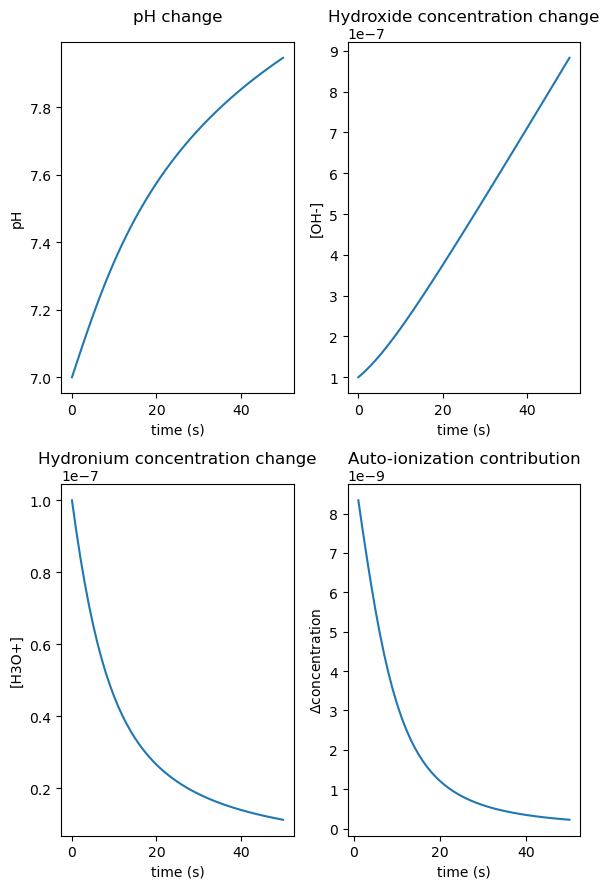

In [8]:
number_of_seconds = 50

#set up tracking array

corrosion = np.zeros((4, number_of_seconds + 1)) # axis: 0-time, 1-[OH-], 2-[H3O+], 3-concentration change
corrosion[0] = np.array(range(number_of_seconds + 1))
corrosion[1, 0] = 10**(-(14-initial_pH)) # convert initial pH to [OH-]
corrosion[2, 0] = 10**(-initial_pH) # convert initial pH to [H3O+]

#run model

for i in range(1, number_of_seconds + 1):
    moles_OH = OH_prod_rate * area
    new_conc_OH = corrosion[1, i-1] + (moles_OH / vol)
    change = scipy.optimize.fsolve(water_equilibrium, 0, args=(new_conc_OH, corrosion[2, i-1]))
    corrosion[1, i] = new_conc_OH - change
    corrosion[2, i] = corrosion[2, i-1] - change
    corrosion[3, i] = change

pH_values = 14 - (-np.log10(corrosion[1]))

# plot the results

fig, axs = plt.subplots(2, 2, figsize=(6,9))

axs[0,0].plot(corrosion[0], pH_values)
axs[0,0].set_xlabel("time (s)")
axs[0,0].set_ylabel("pH")
axs[0,0].set_title("pH change", pad=15)

axs[0,1].plot(corrosion[0], corrosion[1])
axs[0,1].set_xlabel("time (s)")
axs[0,1].set_ylabel("[OH-]")
axs[0,1].set_title("Hydroxide concentration change", pad=15)

axs[1,0].plot(corrosion[0], corrosion[2])
axs[1,0].set_xlabel("time (s)")
axs[1,0].set_ylabel("[H3O+]")
axs[1,0].set_title("Hydronium concentration change", pad=15)

axs[1,1].plot(corrosion[0, 1:], corrosion [3, 1:])
axs[1,1].set_xlabel("time (s)")
axs[1,1].set_ylabel(r"$\Delta$concentration")
axs[1,1].set_title("Auto-ionization contribution", pad=15)

fig.tight_layout();


As the reaction continues, the contribution from the autoionization quickly becomes many orders of magnitude lower than the total concentration of either $\ce{H3O+}$ or $\ce{OH-}$. This shows that the autoionization only has a meaningful effect on the pH when the pH is close to zero. However, in this simple model $\ce{Fe^{2+}}$ is formed as well as $\ce{OH-}$ at each step. As the $\ce{Fe^{2+}}$ (and $\ce{Fe^{3+}}$ which would also form) reacted with the $\ce{OH-}$ to form insoluble species like $\ce{Fe(OH)2}$, the pH would decrease and potentially make this effect important again. As I was trying to think of a way to include the formation of different iron compounds in the model, I realized that there is already a tool for determining which species are likely to form in a corrosive environment, the Pourbaix diagram.

### Moving towards reality

So far, I have only looked at the oxidation of metallic iron to form iron (II), the reduction of oxygen to form hydroxide, and water equilibrium. This makes for a very straightforward model, but also one which is very far removed from the physical world. For example, if the system is neutral, and there is plenty of dissolved oxygen in the water, then $\ce{Fe^{2+}}$ is not the dominating form of oxidized iron. This can be seen in the following Pourbaix diagram for iron (from Wikimedia Commons at [this address](https://upload.wikimedia.org/wikipedia/commons/8/8a/Fe-pourbaix-diagram.svg)):

![Pourbaix diagram for iron](https://upload.wikimedia.org/wikipedia/commons/8/8a/Fe-pourbaix-diagram.svg)

Here, the top dotted blue line represents the oxygen reduction reaction (ORR) and the bottom dotted blue line represents the hydrogen evolution reaction (HER). When there is plenty of oxygen the potential should be close to that of the ORR, so at a neutral pH the diagram tells us that $\ce{Fe2O3}$ is the dominating species of oxidized iron. Since $\ce{Fe2O3}$ is insoluble in water, it also passivates the surface of the iron, reducing the oxidation rate. It is not as effective at passivation as, for example, aluminum oxide, so it slows down corrorosion instead of effectively stopping it. 

- One thing that may be of interest to us here is that, under insulation, it may not be reasonable to assume an oxygen rich environment. If that were the case, and the potential lay closer to that of the HER, then we may be in the $\ce{Fe^{2+}}$ portion of the pourbaix diagram rather than $\ce{Fe2O3}$. Since $\ce{Fe^{2+}}$ is an active species, rather than a passivating one, this could result in an increased oxidation rate. Maybe this is one of the reasons that increased corrosion rates under insulation are observed?

I think at this point it might be good to use a simplified Pourbaix diagram, for example looking at only $\ce{Fe^{2+}}$, $\ce{Fe^{3+}}$, and $\ce{Fe2O3}$. Since the sizes of each region and the locations of the boundary lines depend on the concentrations of the soluble iron species, the model should take these concentrations into account at each step. We eventually want to use the model to look at corrosion under insulation as well, where there are typically elevated temperatures. High temperatures would affect the Pourbaix diagram, so it would be interesting to look at those diagrams as well. My next goals are to include code in the model to create simple Pourbaix diagrams, or at least be able to tell what the dominant iron compound would be, and also to find a way to determine or estimate the amounts of the different iron compounds at each step.

In [9]:
print("More to come")

More to come


Look into a self-consistent model
Define the chemical equations for formation of Fe2O3
Look at pH for steady state conditions
Look also into activity coefficients for the species
Get feedback from Andreas and give him a brief note with a description of the model